# Hello
I would like to present my very first data science project.
This is a simple food recommendation project. It gives ideas of dishes basing on your favourite food.
This is first project version, which works on a "dead" dataset. In to upgrade it, the project may base on API and connect with website to search for most current recipes.

Datasets for this notebook can be downloaded from:
https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

## Libraries and knowledge

In [100]:
from matplotlib.ticker import PercentFormatter
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt # plots
import numpy as np # linear algebra and arrays
import pandas as pd # dataframes and stuff
import scipy as sp # pivot engineering
import seaborn as sns # more plots
import statistics as st # distributions

%matplotlib inline
pd.options.mode.chained_assignment = None #Ignore warning

## Data import and first glimpse into it

### Users

| Column      | Description  |
|-------------|--------------|
| u           | UserID |
| techniques  | Cooking techniques encountered by user|
| items       | Recipes interacted with, in order|
| n_items     | Number of recipes reviewed|
| ratings     | Ratings given to each recipe encountered by this user|
| n_ratings   | Number of ratings in total|


In [2]:
users_pp = pd.read_csv('archive/PP_users.csv')
users_pp.info()
users_pp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25076 entries, 0 to 25075
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   u           25076 non-null  int64 
 1   techniques  25076 non-null  object
 2   items       25076 non-null  object
 3   n_items     25076 non-null  int64 
 4   ratings     25076 non-null  object
 5   n_ratings   25076 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.1+ MB


,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376


### Recipes - preprocessed data
| Column             | Description                                     |
|--------------------|-------------------------------------------------|
| id                 | Recipe ID                                       |
| i                  | Recipe ID mapped to contiguous integers from 0  |
| name_tokens        | BPE-tokenized recipe name                       |
| ingredient_tokens  | BPE-tokenized ingredients list (list of lists)  |
| steps_tokens       | BPE-tokenized steps                             |
| techniques         | List of techniques used in recipe               |
| calorie_level      | Calorie level in ascending order                |
| ingredients_ids    | IDs of ingredients in recipe                    |

In [3]:
recipes_pp = pd.read_csv('archive/PP_recipes.csv')
recipes_pp.info()
recipes_pp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178265 entries, 0 to 178264
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 178265 non-null  int64 
 1   i                  178265 non-null  int64 
 2   name_tokens        178265 non-null  object
 3   ingredient_tokens  178265 non-null  object
 4   steps_tokens       178265 non-null  object
 5   techniques         178265 non-null  object
 6   calorie_level      178265 non-null  int64 
 7   ingredient_ids     178265 non-null  object
dtypes: int64(3), object(5)
memory usage: 10.9+ MB


,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


### Recipes - raw data
| Column         | Description                                                                                                      |
|----------------|------------------------------------------------------------------------------------------------------------------|
| name           | Recipe name                                                                                                      |
| id             | Recipe ID                                                                                                        |
| minutes        | Minutes to prepare recipe                                                                                        |
| contributor_id | User ID who submitted this recipe                                                                                |
| submitted      | Date recipe was submitted                                                                                        |
| tags           | Food.com tags for recipe                                                                                         |
| nutrition      | Nutrition information (calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat |
| steps          | Text for recipe steps, in order                                                                                  |
| description    | User-provided description                                                                                        |

In [4]:
recipes_raw = pd.read_csv('archive/RAW_recipes.csv')
recipes_raw.info()
recipes_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


### Interactions

| Column    | Description         |
|-----------|---------------------|
| user_id   | User ID             |
| recipe_id | Recipe ID           |
| date      | Date of interaction |
| rating    | Rating given        |
| review    | Review text         |

In [5]:
interactions_raw = pd.read_csv('archive/RAW_interactions.csv')
interactions_raw.dropna()
interactions_raw.info()
interactions_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


## Data analysis

### Most often rated recipes

I am gonna do it by counting interactions with specific recipes. I am using value_counts method that creates Series object, which keys are recipe ids and values are numbers of occurrences in the interactions DataFrame. Next I am counting average recipe rate using .groupby() and .mean() methods. Then, all those values are combined to create one complex DataFrame containing recipe ID as its index, name, interactions count and its average rating. This object will be useful in later steps.

In [6]:
# Create a DataFrame to combine recipe id, its name, number of interactions and average rating

# Count interactions
recipes_interactions_count = interactions_raw.value_counts('recipe_id')
recipes_interactions_count.name = 'interactions_count'

# Calculate average rate, change column name and extend the DataFrame
avg_ratings_mean = interactions_raw[['recipe_id', 'rating']].groupby('recipe_id').mean()
avg_ratings_df = avg_ratings_mean.rename(columns = {'rating': 'avg_rating'})
recipes_ratings_df = avg_ratings_df.join(recipes_interactions_count, on ='recipe_id')

# Add recipes names
recipes_names = recipes_raw[['id', 'name']].set_index('id')
recipes_ratings_df = recipes_ratings_df.merge(recipes_names, left_on = 'recipe_id', right_index = True)

# Change columns order
recipes_ratings_df = recipes_ratings_df[['name', 'interactions_count', 'avg_rating']]

To print list of some top recipes I will define a function for it, so that it can be used multiple times. Additionally, I am defining a function that will show statistical data of the DataFrame.

In [7]:
# Define function listing a couple of top recipes
def print_top_recipes(df, column='interactions_count', recipes_shown=10):

    """
    Find and print top recipes sorted by given column.
    Works for DataFrames with column names: 'name', 'interactions_count', 'avg_rating'
    :param df: DataFrame to be inspected
    :param column: column name to sort by, default - 'interactions_count'
    :param recipes_shown: int - number of recipes to be shown, default - 10
    :return: None
    """

    assert {'avg_rating', 'interactions_count', 'name'}.issubset(df.columns), 'Invalid DataFrame columns! Columns that must appear: \'avg_rating\', \'interactions_count\', \'name\'.'

    df.sort_values(by=column, ascending=False, inplace=True)
    for i in range(recipes_shown, 0, -1):
        top_rated_recipe_name = df.iloc[i - 1]['name'].upper()
        top_rated_recipe_interactions = df.iloc[i - 1]['interactions_count']
        top_rated_recipe_rating = df.iloc[i - 1]['avg_rating']
        print(f'Position {i}: \n{top_rated_recipe_name}')
        print(f'Interactions: {top_rated_recipe_interactions}')
        print(f'Average rating: {top_rated_recipe_rating:1.2f} / 5')
        print()

# Define function showing statistical data
def print_interactions_number_stats(df):

    """
    Print number of recipe interactions statistical values.
    Works for DataFrames with column 'interactions_count'
    :param df: DataFrame to be inspected
    :return: None
    """

    assert {'interactions_count'}.issubset(df.columns), 'Invalid DataFrame columns! Columns that must appear: \'avg_rating\', \'interactions_count\', \'name\'.'

    data = df['interactions_count']
    print('Number of recipes:', len(data))
    print('Median:    ', st.median(data))
    print('Quantiles: ', st.quantiles(data, n = 10))
    print('Mean value:', st.mean(data))

Now we can find our desired most popular recipes.

In [8]:
# Find 10 most often rated recipes
print_top_recipes(recipes_ratings_df)

Position 10: 
JAPANESE MUM S CHICKEN
Interactions: 904
Average rating: 4.40 / 5

Position 9: 
KITTENCAL S ITALIAN MELT IN YOUR MOUTH MEATBALLS
Interactions: 997
Average rating: 4.71 / 5

Position 8: 
WHATEVER FLOATS YOUR BOAT  BROWNIES
Interactions: 1220
Average rating: 4.53 / 5

Position 7: 
JO MAMA S WORLD FAMOUS SPAGHETTI
Interactions: 1234
Average rating: 4.42 / 5

Position 6: 
YES  VIRGINIA THERE IS A GREAT MEATLOAF
Interactions: 1305
Average rating: 4.21 / 5

Position 5: 
BEST EVER BANANA CAKE WITH CREAM CHEESE FROSTING
Interactions: 1322
Average rating: 4.33 / 5

Position 4: 
CREAMY CAJUN CHICKEN PASTA
Interactions: 1448
Average rating: 4.54 / 5

Position 3: 
CROCK POT CHICKEN WITH BLACK BEANS   CREAM CHEESE
Interactions: 1579
Average rating: 4.22 / 5

Position 2: 
TO DIE FOR CROCK POT ROAST
Interactions: 1601
Average rating: 4.29 / 5

Position 1: 
BEST BANANA BREAD
Interactions: 1613
Average rating: 4.19 / 5



Let's see it on a chart for a bigger list:

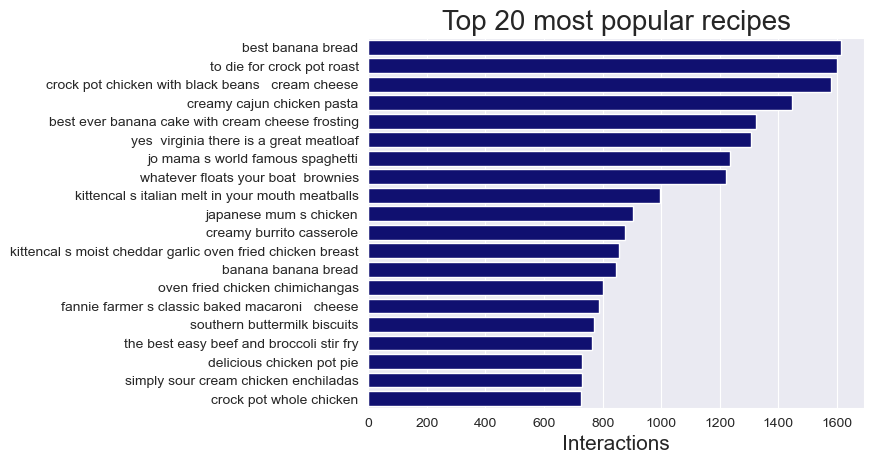

In [63]:
most_popular_recipes = recipes_ratings_df.sort_values(by='interactions_count', ascending=False)[:20]
sns.barplot(data=most_popular_recipes, y='name', x='interactions_count', color='navy')
plt.title('Top 20 most popular recipes', fontsize=20)
plt.xlabel('Interactions', fontsize=15)
plt.ylabel(None)

plt.show()

### Highest rated recipes
At this point I would like to find recipes with highest average rating, but this would probably return a lot of recipes with just one, 5-stars mark.

In [9]:
# Find 10 top-rated recipes

print_top_recipes(recipes_ratings_df, column='avg_rating')

Position 10: 
BANGKOK BURGERS
Interactions: 1
Average rating: 5.00 / 5

Position 9: 
HOMEMADE ZAHTAR
Interactions: 3
Average rating: 5.00 / 5

Position 8: 
STILTON AND POTATO SOUP WITH CHEESE CROUTONS
Interactions: 3
Average rating: 5.00 / 5

Position 7: 
CHICKEN BREASTS GLAZED WITH HOT PEPPER JELLY
Interactions: 3
Average rating: 5.00 / 5

Position 6: 
CHEESE AND CRACKER MEAT LOAF
Interactions: 1
Average rating: 5.00 / 5

Position 5: 
KIWI CHICKEN TOSTADAS
Interactions: 1
Average rating: 5.00 / 5

Position 4: 
SPINACH AND CHICKPEA CURRY
Interactions: 1
Average rating: 5.00 / 5

Position 3: 
TURKEY PICCATA
Interactions: 1
Average rating: 5.00 / 5

Position 2: 
BEEFSTEAK AND MUSHROOM PIE
Interactions: 1
Average rating: 5.00 / 5

Position 1: 
MINI BUFFALO CHICKEN CHEESESTEAKS
Interactions: 1
Average rating: 5.00 / 5



We got exactly the expected result. So let's make the results more objective and let's set a threshold below which we will not consider results as valid. This could be some constant value (e.g. 20 or 50 ratings), but we want it to be prone to overall ratings number distribution. So let's check what does this distribution look like. To make it easier let's define a function that creates a Pareto distribution plot.

In [10]:
def pareto(data, logarithmic=True):

    """
    Create Pareto chart to show values distribution in given data set.
    :param data: Data to check distribution
    :param logarithmic: Whether to make the x axis logarithmic or not
    :return: None
    """

    # Define colors
    color_bar = 'navy'
    color_line = 'tomato'

    # Create chart
    fig, ax = plt.subplots()

    # Interactions number distribution
    plot_bins = range(min(data), max(data) + 1) # +1 to avoid cutting last value
    bin_interactions_sum, bin_endpoints, bin_artists = plt.hist(data, bins=plot_bins, rwidth=0.8, align='left', color=color_bar)

    # Cumulated interaction sum shown as percentage of total
    cumulated_interactions = np.cumsum(bin_interactions_sum)
    cumulated_interactions_percent = cumulated_interactions/bin_interactions_sum.sum()*100

    # Set range of x for cumulated sum so that it starts with 1
    plot2_x = range(min(data), max(data))

    # Add second plot
    ax2 = plt.twinx()
    ax2.plot(plot2_x, cumulated_interactions_percent, 'o-', color=color_line)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    # Chart description
    if logarithmic:
        plt.gca().set_xscale("log")
        ax.set_xlabel('Number of interactions (logarithmic scale)')
    else:
        ax.set_xlabel('Number of interactions')

    plt.title('Interactions number distribution')
    ax.grid(False)
    ax2.grid(False)
    ax2.tick_params(axis='y', colors=color_line)

    plt.show()

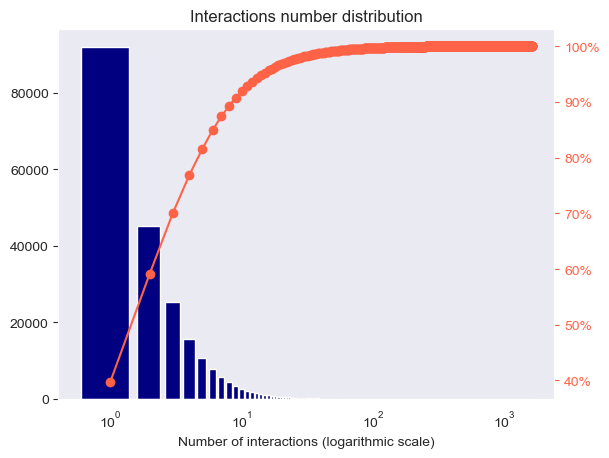

In [11]:
pareto(recipes_ratings_df['interactions_count'])

In [12]:
# Print some statistical values

print_interactions_number_stats(recipes_ratings_df)

Number of recipes: 231637
Median:     2
Quantiles:  [1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 5.0, 9.0]
Mean value: 4.888541122532238


After having a look at the chart above and statistical data I decided to set the first threshold as >= 10 interactions, which will cut off majority of lowest popular recipes.

In [13]:
# Create DataFrame with recipes that have minimum 10 interactions

top_rated_recipes_min_interactions = 10
recipes_ratings_df_top_list = recipes_ratings_df[recipes_ratings_df['interactions_count'].ge(top_rated_recipes_min_interactions)]
print_top_recipes(recipes_ratings_df_top_list, column = 'avg_rating')

Position 10: 
GARLICKY CLAM DIP
Interactions: 10
Average rating: 5.00 / 5

Position 9: 
WW POTATO GRATIN 5 POINTS
Interactions: 10
Average rating: 5.00 / 5

Position 8: 
ROAST PORK PUERTORICANO
Interactions: 10
Average rating: 5.00 / 5

Position 7: 
BEAUTIFUL BETH  DRINK
Interactions: 10
Average rating: 5.00 / 5

Position 6: 
MARINADE FOR LAMB CHOPS   OR ANY OTHER MEAT
Interactions: 10
Average rating: 5.00 / 5

Position 5: 
FARMHOUSE POTATO CHEESE SOUP
Interactions: 10
Average rating: 5.00 / 5

Position 4: 
HAWAIIAN PINEAPPLE ICED TEA
Interactions: 10
Average rating: 5.00 / 5

Position 3: 
SHRIMP LUNCHEON SANDWICHES   PRETTY AND PINK
Interactions: 10
Average rating: 5.00 / 5

Position 2: 
BEEF BOLOGNESE   DELISH
Interactions: 10
Average rating: 5.00 / 5

Position 1: 
BEER BRATS WITH ONIONS AND PEPPERS
Interactions: 13
Average rating: 5.00 / 5



As we can see, setting minimum interactions count to just 10 interactions let us filter 90% of recipes, but - sorry for that - we still got only 5-star results. Let's check the distribution and statistical data now:

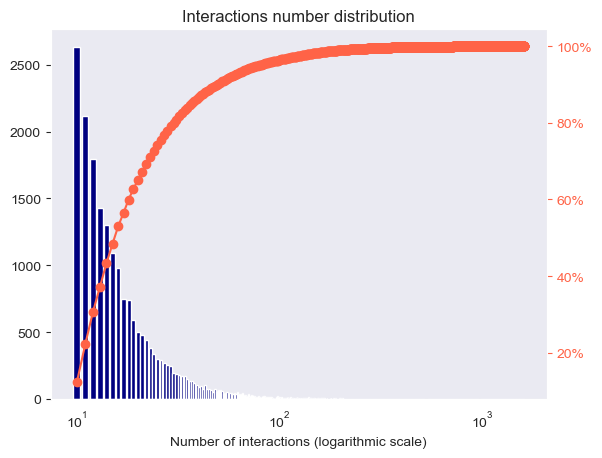

In [14]:
pareto(recipes_ratings_df_top_list['interactions_count'])

In [15]:
# Print - again - some statistical values

print_interactions_number_stats(recipes_ratings_df_top_list)

Number of recipes: 21399
Median:     16
Quantiles:  [10.0, 11.0, 12.0, 14.0, 16.0, 19.0, 23.0, 31.0, 50.0]
Mean value: 28.235431562222534


Let's filter it once again and check how it looks for at least 100 interactions:

In [16]:
# Create DataFrame with recipes that have minimum 100 interactions

top_rated_recipes_min_interactions = 100
recipes_ratings_df_top_list = recipes_ratings_df[recipes_ratings_df['interactions_count'].ge(top_rated_recipes_min_interactions)]
print_top_recipes(recipes_ratings_df_top_list, column='avg_rating')

Position 10: 
WHITE FISH IN HERBED BUTTER
Interactions: 100
Average rating: 4.82 / 5

Position 9: 
EASY  FESTIVE CHOCOLATE HOLIDAY PRETZELS
Interactions: 122
Average rating: 4.84 / 5

Position 8: 
CROUTONS
Interactions: 100
Average rating: 4.84 / 5

Position 7: 
INDIVIDUAL CREAM CHEESE DANISH
Interactions: 135
Average rating: 4.84 / 5

Position 6: 
SPICED SWEET ROASTED RED PEPPER   FETA HUMMUS
Interactions: 117
Average rating: 4.85 / 5

Position 5: 
LINDA S CHEESECAKE STUFFED STRAWBERRIES
Interactions: 131
Average rating: 4.85 / 5

Position 4: 
SWEET  CREAMY COLESLAW
Interactions: 139
Average rating: 4.85 / 5

Position 3: 
MONTEREY CHICKEN ROLLS
Interactions: 134
Average rating: 4.87 / 5

Position 2: 
BROWN SUGAR BUNDT CAKE
Interactions: 118
Average rating: 4.92 / 5

Position 1: 
MEXICAN STACK UP  RSC
Interactions: 217
Average rating: 4.99 / 5



Let's see it on a chart

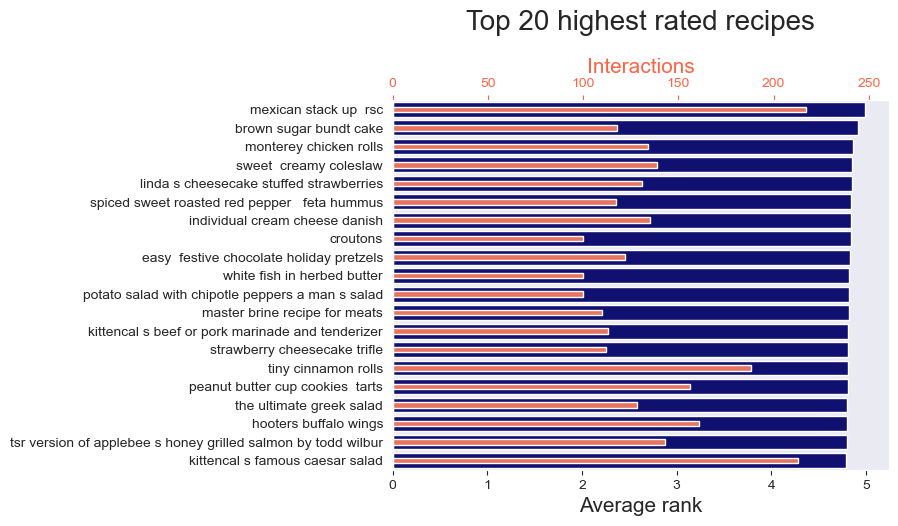

In [99]:
most_popular_recipes = recipes_ratings_df_top_list.sort_values(by='avg_rating', ascending=False)[:20]
fig, ax = plt.subplots()
sns.barplot(data=most_popular_recipes, y='name', x='avg_rating', color='navy')
plt.title('Top 20 highest rated recipes', fontsize=20, pad=20)
plt.xlabel('Average rank', fontsize=15)
plt.ylabel(None)

ax2_color = 'tomato'
ax2 = plt.twiny()
sns.barplot(data=most_popular_recipes, y='name', x='interactions_count', color=ax2_color, width=0.3)
ax2.set_xlabel('Interactions', color=ax2_color, fontsize=15)
ax2.tick_params(colors=ax2_color)
ax2.margins(x=0.2)

ax.grid(False)
ax2.grid(False)

plt.show()

Now we got a really nice top recipes list, which means we can head to the supermarket for some tex-mex ingredients :)

## Recommendation tools

### Creating DataFrame for pivot table

We will have to limit size of the table, because it would get too big to be processed by Pandas. To do so we will delete users with less than 3 interactions and recipes with less than 10 interactions.

In [17]:
# Limit sets of recipes and users

min_recipe_interactions = 10
recipes_valid = interactions_raw['recipe_id'].value_counts()
recipes_valid = recipes_valid[recipes_valid.ge(min_recipe_interactions)]
interactions_valid = interactions_raw[interactions_raw['recipe_id'].isin(recipes_valid.index)]

min_user_interactions = 3
users_valid = interactions_raw['user_id'].value_counts()
users_valid = users_valid[users_valid.ge(min_user_interactions)]
interactions_valid = interactions_valid[interactions_valid['user_id'].isin(users_valid.index)]


In [18]:
# Create a new DataFrame combining user id, recipe name and its rating

rated_recipes = interactions_valid.merge(recipes_raw, left_on='recipe_id', right_on='id')
rated_recipes = rated_recipes[['user_id', 'name', 'rating']]
print(len(rated_recipes))
rated_recipes.head()

473751


,user_id,name,rating
0,56680,potato crab chowder,5
1,183565,potato crab chowder,5
2,101823,potato crab chowder,5
3,349752,potato crab chowder,5
4,446143,potato crab chowder,4


In [19]:
# Create pivot table to gather users and their ratings in one table

pivot = pd.pivot_table(rated_recipes, values='rating', index='user_id', columns='name')
pivot.head()

name,1 00 tangy chicken recipe,1 1 1 tempura batter,1 2 3 4 tater tot casserole,1 2 3 4 cake,1 2 3 4 cake with caramel icing,1 2 3 apple crisp,1 2 3 black bean salsa dip,1 cup of coffee pork roast,1 hour ham and bean soup,1 minute cake,...,zucchini spoon bread,zucchini squash rice casserole,zucchini stuffing,zucchini tart with gruyere cheese and herbs,zucchini they will eat,zucchini with summer herbs,zucotte,zuppa di pesce cioppino or fish stew,zuppa toscana soup olive garden clone,zurie s overnight no knead bread
user_id,,,,,,,,,,,,,,,,,,,,,
1533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Engineering pivot table

We will do it in following steps:
1. Value normalization
2. Filling NaN values with 0
3. Transposing the pivot for the next step
4. Dropping columns with values of 0
5. Using scipy package to convert to sparse matrix format for memory management


In [20]:
# Step 1
pivot_n = pivot.apply(lambda x: (x - np.mean(x)) / (np. max(x) - np.min(x)), axis = 1)
# Step 2
pivot_n.fillna(0, inplace = True)
# Step 3
pivot_n = pivot_n.T
# Step 4
pivot_n = pivot_n.loc[:, (pivot_n != 0).any(axis = 0)]
# Step 5
pivot_sparse = sp.sparse.csr_matrix(pivot_n.values)

### Let's see what we got
Below we can see the pivot table. It contains of mostly zeros - that's why we used sparse matrix!


In [22]:
pivot_n.head()

user_id,1533,1535,1634,1676,1773,1792,1891,1962,2059,2148,...,2002227190,2002232072,2002236201,2002245770,2002254807,2002279220,2002293812,2002295280,2002312797,2002313158
name,,,,,,,,,,,,,,,,,,,,,
1 00 tangy chicken recipe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1 1 1 tempura batter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1 2 3 4 tater tot casserole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1 2 3 4 cake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1 2 3 4 cake with caramel icing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cosine similarity model

We will calculate cosines of angles between vectors representing particular recipes. This will be used to establish similarity between them.

In [42]:
# Model based on recipe similarity
recipe_similarity = cosine_similarity(pivot_sparse)

# DataFrame of recipes similarity
recipe_similarity_df = pd.DataFrame(recipe_similarity, index=pivot_n.index, columns=pivot_n.index)

# Show slice of similarity array
recipe_similarity[0:10, 0:10]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.50252331e-02,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.47636419e-03,  0.00000000e+00, -1.80448373e-03,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.16952491e-05,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.

Above we can see fragment of similarity array. Its values represent cosine of angle between vectors: from 0 - no similarity to 1 - full similarity. We can see what happens on the diagonal - all values are 1, which in fact is obvious - all vectors are equal to themselves! The other aspect is symmetry - if record A relates to record B with given value, record B relates to record A with the same value!

In [38]:
def recommend_recipe(liked_recipe):
    recipe_similarity_df.sort_values(by=liked_recipe, ascending=False, inplace=True)
    print('Recommended, because you liked:', liked_recipe)
    for number in range(1, 6):
        recommended_recipe = recipe_similarity_df.index[number]
        match = float(recipe_similarity_df.iloc[number][liked_recipe]) * 100
        print(f'Top {number}: {recommended_recipe}, match: {match:2.2f} %')

To properly use our recommendation method an exact base recipe name must be given as an argument. So let's prepare an easy searching tool that finds recipes names that contain given phrase. Then, let's check results of the final project!

In [42]:
def find_recipe(name, max_recipes_shown=20):
    # Search for recipes which names contain searched phrase. Use only recipes available in similarity model.
    found_recipes_df_index = recipe_similarity_df[recipe_similarity_df.index.str.contains(name)]
    # Create a DataFrame from recipes_ratings_df containing only found recipes
    found_recipes_df = recipes_ratings_df[recipes_ratings_df['name'].isin(found_recipes_df_index.index)]
    # Sort DataFrame
    found_recipes_df.sort_values(by = 'interactions_count', ascending = False, inplace = True)

    if max_recipes_shown > len(found_recipes_df):
        max_recipes_shown = len(found_recipes_df)

    # Print found recipes
    print(f'{len(found_recipes_df)} recipes found. Top {max_recipes_shown} of them:\n')

    print(found_recipes_df.head(max_recipes_shown))

In [41]:
find_recipe('japanese', 10)

40 recipes found. Top 10 of them:

                                                        name  \
recipe_id                                                      
68955                                 japanese mum s chicken   
71472                           benihana japanese fried rice   
90032                                    japanese cheesecake   
42722         niku jaga  japanese beef stew in the crock pot   
111829     japanese steakhouse ginger salad dressing copy...   
29968                  mom s yakisoba japanese fried noodles   
43101                           japanese vinegared cucumbers   
215843                                 japanese curry  wafuu   
30380                             grilled japanese swordfish   
228780                            japanese chicken drumettes   

           interactions_count  avg_rating  
recipe_id                                  
68955                     904    4.398230  
71472                      80    4.550000  
90032               

In [432]:
recommend_recipe('japanese cheesecake')

Recommmended, because you liked: japanese cheesecake
Top 1: virginia s easy lasagne, match: 39.68 %
Top 2: mean chef s french fries, match: 26.07 %
Top 3: cocoa honey cake, match: 25.98 %
Top 4: devonshire potato mushroom pie, match: 22.83 %
Top 5: tastes like apple pie apple squares, match: 12.60 %
